In [39]:
#attach your Google drive to read write file
# drive.mount('/content/drive')

In [40]:
## Importing the libraries:
import os, sys

import cachetools.func

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

#WHO Health Observatory API wrapper

Below is a python code that you can use to get health related data for any country in the world from World Health Organisation (WHO). To learn more about the description of the data available there check their [Global Health Observatory](https://www.who.int/data/gho) page. In particular, you can refer to the [indicators](https://www.who.int/data/gho/data/indicators) and [Data API](https://www.who.int/data/gho/info/gho-odata-api) pages.

In [41]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')

def agegrp_func(x):
  '''
  Function to format how age group is presented
  WHO uses AGE20-30, we want just 20-30
  '''
  if 'AGELT1' in x:
    y = '0-1'
  elif 'AGE85' in x:
    y = '85+'
  else:
    y=x.replace('AGE','')

  return y

def agegrp_mid(x):
  '''
  Function to calculate the mid age of an age group
  '''
  if 'AGELT1' in x:
    y = -3
  elif 'AGE85' in x:
    y = 87
  else:
    try:
      y=int(np.mean([int(i) for i in x.replace('AGE','').split('-')]))
    except:
      y = int(x.replace('AGE','').split('-')[0])
  return y  

class whoapi():
  '''
  This class defines methods to get data from World Health Organisation (WHO) API
  The different WHO health and related data is structured by country and indicator id (ids) 
  For example 
    Country = ETH
    indicatorid='LIFE_0000000029' 
  describes the probability of dying in age groups for Ethiopia
  Reference: for more information about available WHO data, refer
  https://www.who.int/data/gho  
  '''
  def __init__(self, dim='GHO',**kwargs):
    #
    self.url = f"http://apps.who.int/gho/athena/api/{dim}"
    self.verbose = kwargs.get('verbose',0)

  @staticmethod
  def age_sex_stem(df):    
    '''
    To nicely format AGE and SEX columns
    '''
    if 'AGEGROUP' in df.columns:
      df['MidAge'] = df['AGEGROUP'].map(agegrp_mid)
      df['AGEGROUP'] = df['AGEGROUP'].map(agegrp_func)       
      df = df.sort_values('MidAge').reset_index().drop(columns=['index'])
      
    if 'SEX' in df.columns:
      df['SEX'] = df['SEX'].map(lambda x:{'MLE':'Male',
                                              'FMLE':'Female',
                                              'BTSX':'Both'}.get(x,x))
    return df    

  def get_ids(self,s):
    df = self.dfid

    name = s
    if isinstance(s,str):
      name = [s]    

    dflist = [] 
    for d in name:
      dflist.append(df[df['id'].map(lambda x : d in x)])

    #try:
    df = pd.concat(dflist)
    #except:
    #  df = pd.DataFrame()

    return df

  def get_gho_data(self, id, fdict=None, 
                   url=None,verbose=None):
    '''
    given 
      id: indicator id, 
      fdict: dictionary of filters e.g {'COUNTRY':ETH,'YEAR':2016} ethiopian data from 2016
      url (optional)
      verbose: feedback level (0 -  less info to print; >=2 debug mode)
    get data from WHO server and return it as pandas DataFrame 
    '''
    #
    verbose = self.verbose if verbose is None else verbose
    #
    ids = id
    if isinstance(id,list):
      ids = ','.join(id)

    if url is None:
      url = f"{self.url}/{ids}.csv"

    if verbose>1:
      print('API url:',url)

    if not fdict is None:
      url += '?filter=' + ";".join([f"{k}:{v}" for k, v in fdict.items()])
    
    df = pd.read_csv(url)
    df = df.dropna(axis=1, how='all')
    try:
      df = df.drop(columns=['Comments'])
      df = df.drop(columns=['Comments'])
    except:
      #print('not dropping Comments')
      pass

    return df

  def country_data(self,ids,countries=['ETH'],year=2016):    
    '''
    This is a wrapper to 
      method: get_gho_data 
    This method allows one easily to pass multiple countries in a list
    '''
    if isinstance(countries,str):
      countries = [countries]

    dflist = []
    verbose=self.verbose
    for c in countries:
      print(f'processing country={c}')
      df = self.get_gho_data(ids,fdict={'COUNTRY':c,'YEAR':year},verbose=verbose)
      print(df.shape)
      verbose += 2
      dflist.append(df)

    df = pd.concat(dflist)
    print('all_df.shape',df.shape)
    return df

  def death_rates(self,**kwargs):
    '''
    This method fetchs data for the death rate from WHO server. 
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''
    name = 'LIFE_0000000029'
    try:
      return self.age_sex_stem(self.country_data(name,**kwargs))
    except:
      return self.country_data(name,**kwargs)

  def dying_prob(self, **kwargs):
    '''
    This method fetchs the probability of dying data at a given age from WHO serer  
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''

    name = 'LIFE_0000000030'
    df = self.country_data(name,**kwargs)
    try:
      return self.age_sex_stem(df)
    except:
      raise
      return df  
     
  def prop_dying_ncd_3070(self,**kwargs):
    name = 'NCDMORT3070'
    df = self.country_data(name,**kwargs)
    try:
      return self.age_sex_stem(df)
    except:
      return df

##Challenge 1
Below we use the `whoapi` class defined above to fetch data as pandas dataframe. The following plot is produced using the data stored in `df_pd` variable defined in the next cell. 

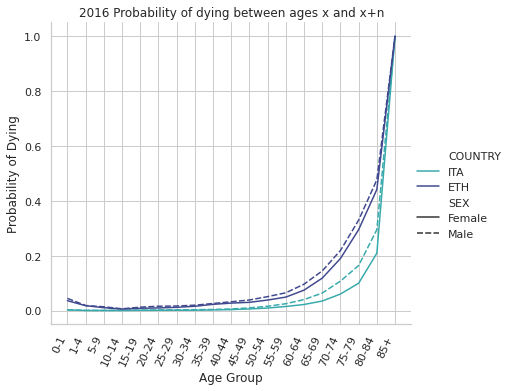


#### **Your task is to make a plot similar to this plot. You may use different colors, but the x axis labels should be rotated to make it look nice and readable. The over all quality of the plot should be as good or better than this plot. We used something like the following to the above plot**
```python
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("whitegrid"):
  chart = sns.relplot()
```
 
**The plot should reflect your country (use your country iso-3 three letter code) and compare it to other countries that you like. Make other useful plots if you can.**

In [42]:
'''
Here is a starter code to give you a hint
'''
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries
death_data = hapi.dying_prob(countries=["KEN","AFG", 'FRA'])
death_data.head()

processing country=KEN
(38, 9)
processing country=AFG
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=FRA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (114, 9)


,GHO,PUBLISHSTATE,YEAR,REGION,COUNTRY,AGEGROUP,SEX,Display Value,Numeric,MidAge
0,LIFE_0000000030,PUBLISHED,2016,AFR,KEN,0-1,Male,0.040,0.03971,-3
1,LIFE_0000000030,PUBLISHED,2016,EMR,AFG,0-1,Female,0.049,0.04925,-3
2,LIFE_0000000030,PUBLISHED,2016,EMR,AFG,0-1,Male,0.057,0.05695,-3
3,LIFE_0000000030,PUBLISHED,2016,EUR,FRA,0-1,Female,0.003,0.00290,-3
4,LIFE_0000000030,PUBLISHED,2016,AFR,KEN,0-1,Female,0.033,0.03320,-3


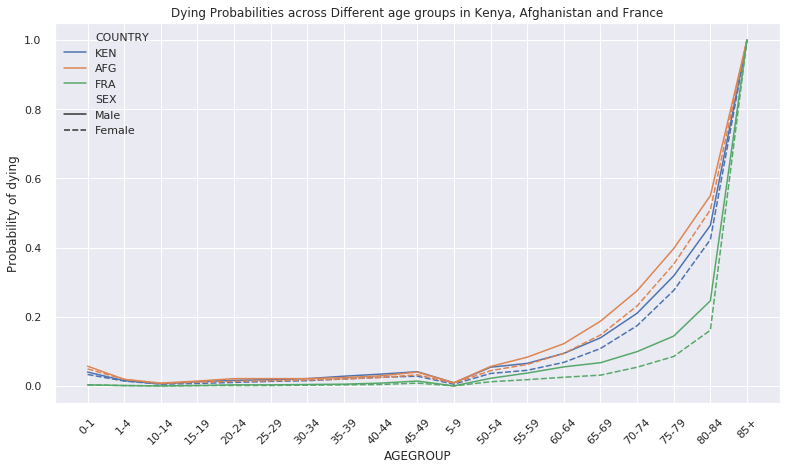

In [43]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(death_data['AGEGROUP'], death_data['Display Value'], hue = death_data['COUNTRY'], style = death_data['SEX'])
plt.xticks(rotation=45)
plt.ylabel('Probability of dying')
plt.title('Dying Probabilities across Different age groups in Kenya, Afghanistan and France')
plt.savefig('probability of dying.jpg')

France has a lower dying probability when approaching older ages compared to Kenya and Afghanistan.

##Challenge 2

Plot death rates as a function of age by calling the `death_rate` method. You can either use your choice of countries or use `countries=['ETH','ITA']`.

In [44]:
death_rate = hapi.death_rates(countries = ['KEN', 'FRA', 'AFG'])
death_rate.head()

processing country=KEN
(38, 9)
processing country=FRA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=AFG
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
all_df.shape (114, 9)


,GHO,PUBLISHSTATE,YEAR,REGION,COUNTRY,AGEGROUP,SEX,Display Value,Numeric,MidAge
0,LIFE_0000000029,PUBLISHED,2016,AFR,KEN,0-1,Male,0.041,0.04109,-3
1,LIFE_0000000029,PUBLISHED,2016,EUR,FRA,0-1,Female,0.003,0.00291,-3
2,LIFE_0000000029,PUBLISHED,2016,EUR,FRA,0-1,Male,0.003,0.00317,-3
3,LIFE_0000000029,PUBLISHED,2016,EMR,AFG,0-1,Female,0.051,0.05142,-3
4,LIFE_0000000029,PUBLISHED,2016,AFR,KEN,0-1,Female,0.034,0.03417,-3


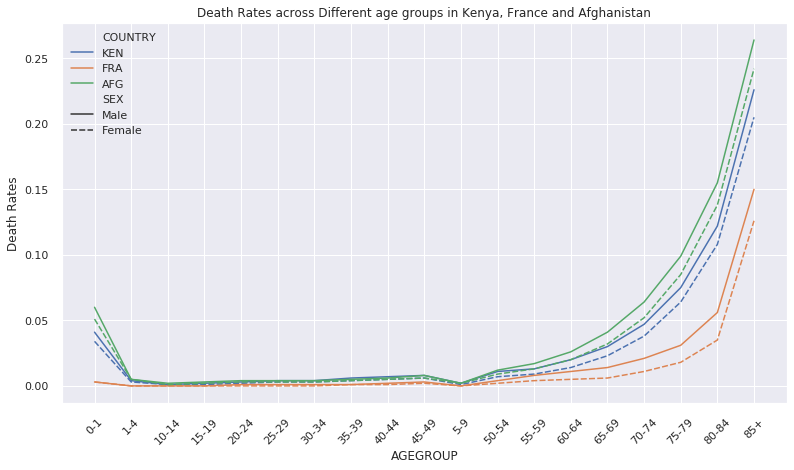

In [45]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(death_rate['AGEGROUP'], death_rate['Display Value'], hue = death_rate['COUNTRY'], style = death_rate['SEX'])
plt.xticks(rotation=45)
plt.ylabel('Death Rates')
plt.title('Death Rates across Different age groups in Kenya, France and Afghanistan')
plt.style.use('seaborn-pastel')
plt.savefig('Death Rates.jpg')

Again France has the lowest death rate especially when approaching old age compared to Kenya and Afghnaistan. But the trend is uniform, death rates increases with age.

##Challenge 3

Plot the probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease. To obtain the data call the whoapi as follows 
```python
df_pd_ncd = hapi.prop_dying_ncd_3070(countries=["ETH","ITA"])
print('dying prob df.shape',df_all_ncd.shape)
```

Your plot should look as follows (but the contries being your country and multiple other contries you want to compare)

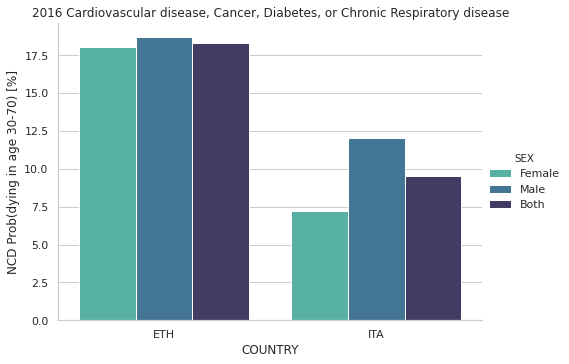



In [46]:
df_pd_ncd = hapi.prop_dying_ncd_3070(countries=["KEN", "FRA", "AFG"])
df_pd_ncd.head()

processing country=KEN
(3, 8)
processing country=FRA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=AFG
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
all_df.shape (9, 8)


,GHO,PUBLISHSTATE,YEAR,REGION,COUNTRY,SEX,Display Value,Numeric
0,NCDMORT3070,PUBLISHED,2016,AFR,KEN,Female,13.0,13.0
1,NCDMORT3070,PUBLISHED,2016,AFR,KEN,Male,13.9,13.9
2,NCDMORT3070,PUBLISHED,2016,AFR,KEN,Both,13.4,13.4
0,NCDMORT3070,PUBLISHED,2016,EUR,FRA,Female,7.2,7.2
1,NCDMORT3070,PUBLISHED,2016,EUR,FRA,Male,14.1,14.1


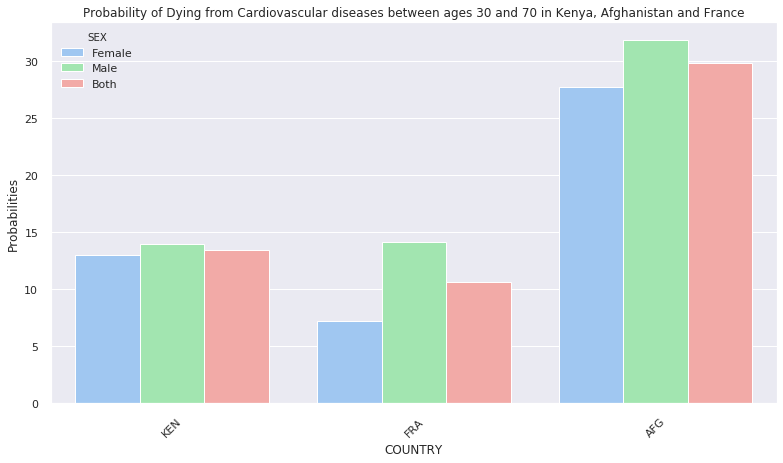

In [47]:
fig, ax = plt.subplots(figsize=(13,7))
sns.barplot(x = df_pd_ncd['COUNTRY'], y = df_pd_ncd['Display Value'], hue = df_pd_ncd['SEX'])
plt.xticks(rotation=45)
plt.ylabel('Probabilities')
plt.title('Probability of Dying from Cardiovascular diseases between ages 30 and 70 in Kenya, Afghanistan and France')
plt.style.use('seaborn-pastel')
plt.savefig('Probabilty of dying(cardiovascular).jpg')

Chances of dying are highest in males across the three countries. Afghanistan has the highest chances of the 3 countries. In Kenya, it's evenly distributed across the genders and range around the same value as the highest record in France (Men).

# COVID19 Data Analysis 

Below is a python class that you could use to download latest COVID19 data from John Hopkins Server for any contry in the world.

In [48]:
#-----      
#-----
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
  # fix region names
  for p in pairs:
    df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

  return df

#-----
def merge_df_data(df1,df2):
  return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
  out = []
  for x in args:
    if isinstance(x,str):
      out.append(x)
  
  return '_'.join(out)


class covid_data():
  '''
  Python class to obtain global COVID19 data from 
  John Hopkins GIT repository. This data is updated daily, 
  and the most upto date information available on the web.  
  '''
  def __init__(self,**kwargs):

    #
    nrow = kwargs.get('nrow',None)
    self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

  @staticmethod
  def create_ts(df):
    ts=df
    columns = ts['region']
    ts=ts.drop(['Province/State', 
                'Country/Region',
                'Lat', 
                'Long',
                'Population'], 
               axis=1).set_index('region').T    

    ts.columns = columns 
    ts=ts.fillna(0)
    #
    ts.index.name = 'Date'
    return ts

  def search_agg(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():

      #pd.columns(columns=)
      df_list= []     
      for n in name:
        df = v[v[col]==n].set_index(col).filter(regex='/20')
        df_list.append(df.sum(axis=0))

      df = pd.concat(df_list,axis=1, sort=False)
      df.columns = name
      out[k] = df

      # if ts:                
      #   out[k] = self.create_ts(df)
      # else:
      #   out[k] = df.T

    return out

  def search(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():
      if ts:                
        out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
      else:
        out[k] = v[v[col] in name].T
    
    return out

  @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
  def get_csseg_data(self, nrow=None):
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
    path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

    # 
    
    url = f'{path}/time_series_covid19_confirmed_global.csv'
    confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_deaths_global.csv'
    dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_recovered_global.csv'
    
    recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    print(confirmed.head())
    #
    return confirmed, dead, recovered


## Challenge 4:
**Compare the number of COVID19 cases, deaths, and recovries with respect to your neighbouring contries**

After successfully doing this and the previous challenges, share your final nice plot on twitter by adding #10AcademyCovid19Response hashtag. Include your twitter post links in this notebook, or as a comment when you submit. 

**Your task is to produce a plot like this for your country and the neighbouring countries for #cases, #deaths, and #recoveries. Any improvement you can make is a plus.**
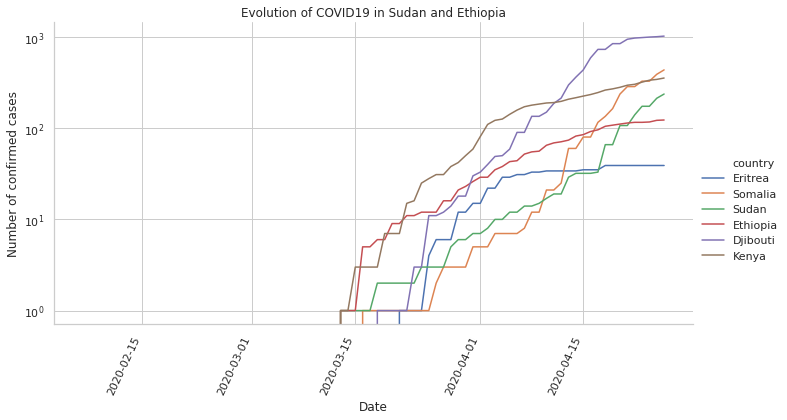

## Example

We can obtain the COVID19 number of confirmed cases, number of dead, and number of recovered counts for any subset of countries (the example below is for Ethiopia and its 5 neighbours) using the above class as follows: 

```python
cd = covid_data()
cd.confirmed.head()
countries = ['Sudan','Ethiopia','Djibouti','Kenya','Eritrea','Somalia']
mm = cd.search_agg(countries)
```
The output mm is a python dict of  #confirmed cases, #dead, and #recovered dataframes i.e `mm['dead']` is a data frame which contains countries as columns and date as rows.

You can transform the `mm` dict of dataframes into single data frame by using the following code 

```python
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
  df = mm[ctype].stack().reset_index()/
  #print(df.head())
  df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
  if ix==0:
    df['date'] = pd.to_datetime(df['date'])
    dfall = df
  else:
    dfall[ctype] = df[ctype]
```
If you issue `print(dfall.head())` you should get something like this
```
date	        country	       confirmed	dead	recovered
0	2020-01-22	Sudan	          0	      0	     0
1	2020-01-22	Ethiopia	       0          0	     0
2	2020-01-22	Djibouti	       0	      0	     0
3	2020-01-22	Kenya	          0	      0	     0
4	2020-01-22	Eritrea	        0	      0	     0
```

Once you have the data in the the right data frame, use groupby to get data per country, and use seaborn to do the plotting. Show plot for the all  the three i.e. cases, deaths, and recoveries 

In [49]:
cd = covid_data()
# cd.confirmed.head()
countries = ['Kenya','Tanzania','Uganda','Somalia','Ethiopia','Sudan']
mm = cd.search_agg(countries)
mm

  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/25/20  6/26/20  6/27/20  6/28/20  \
0        0        0        0  ...    30175    30451    30616    30967   
1        0        0        0  ...     2192     2269     2330     2402   
2        0        0        0  ...    12445    12685    12968    13273   
3        0        0        0  ...      855      855      855      855   
4        0        0        0  ...      212      212      259      267   

   6/29/20  6/30/20  7/1/20  7/2/20  7/3/20  7/4/20  
0    31238    31517   3183

{'confirmed':          Kenya  Tanzania  Uganda  Somalia  Ethiopia  Sudan
 1/22/20      0         0       0        0         0      0
 1/23/20      0         0       0        0         0      0
 1/24/20      0         0       0        0         0      0
 1/25/20      0         0       0        0         0      0
 1/26/20      0         0       0        0         0      0
 ...        ...       ...     ...      ...       ...    ...
 6/30/20   6366       509     889     2924      5846   9257
 7/1/20    6673       509     893     2924      5846   9573
 7/2/20    6941       509     902     2944      5846   9573
 7/3/20    7188       509     911     2944      5846   9663
 7/4/20    7577       509     927     2961      5846   9767
 
 [165 rows x 6 columns],
 'dead':          Kenya  Tanzania  Uganda  Somalia  Ethiopia  Sudan
 1/22/20      0         0       0        0         0      0
 1/23/20      0         0       0        0         0      0
 1/24/20      0         0       0        0         0

In [50]:
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
  df = mm[ctype].stack().reset_index()
  #print(df.head())
  df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
  if ix==0:
    df['date'] = pd.to_datetime(df['date'])
    dfall = df
  else:
    dfall[ctype] = df[ctype]
dfall.head()

,date,country,confirmed,dead,recovered
0,2020-01-22,Kenya,0,0,0
1,2020-01-22,Tanzania,0,0,0
2,2020-01-22,Uganda,0,0,0
3,2020-01-22,Somalia,0,0,0
4,2020-01-22,Ethiopia,0,0,0


In [51]:
dfall['date'].head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: date, dtype: datetime64[ns]

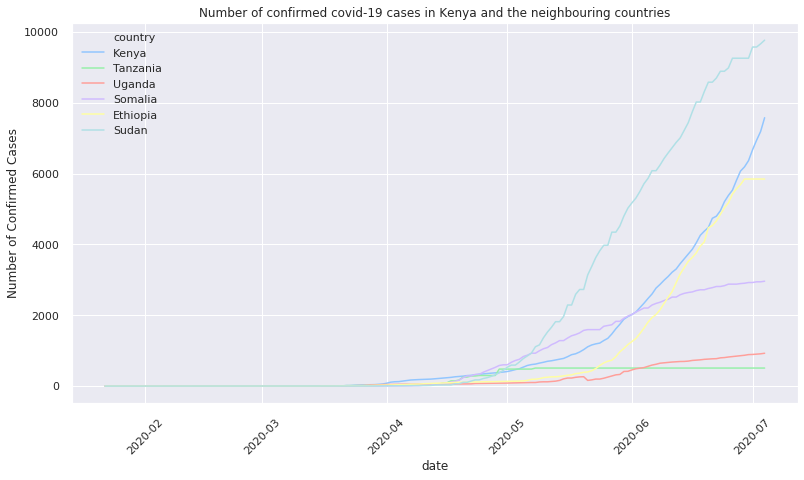

<Figure size 576x396 with 0 Axes>

In [52]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(dfall['date'], dfall['confirmed'], hue = dfall['country'])
plt.xticks(rotation=45)
plt.ylabel('Number of Confirmed Cases')
plt.title('Number of confirmed covid-19 cases in Kenya and the neighbouring countries')
plt.show()
plt.savefig('confirmed_casess.jpeg')

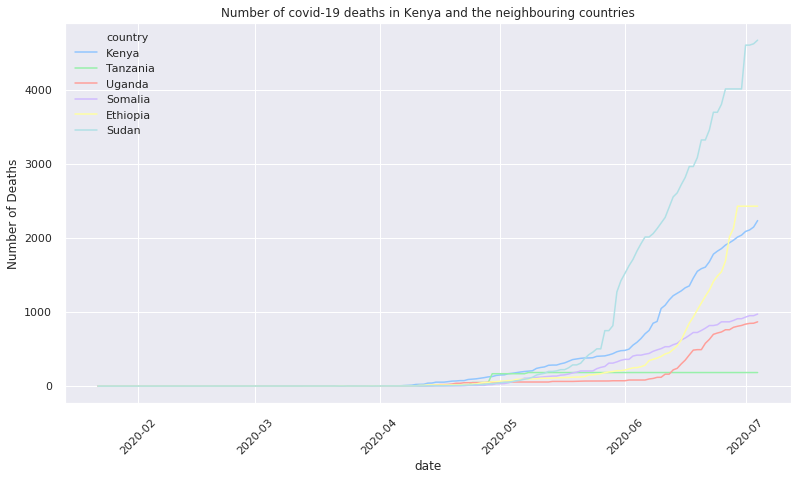

<Figure size 576x396 with 0 Axes>

In [53]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(dfall['date'], dfall['recovered'], hue = dfall['country'])
plt.xticks(rotation=45)
plt.ylabel('Number of Deaths')
plt.title('Number of covid-19 deaths in Kenya and the neighbouring countries')
plt.show()
plt.style.use('seaborn')
plt.savefig('deaths.jpg')

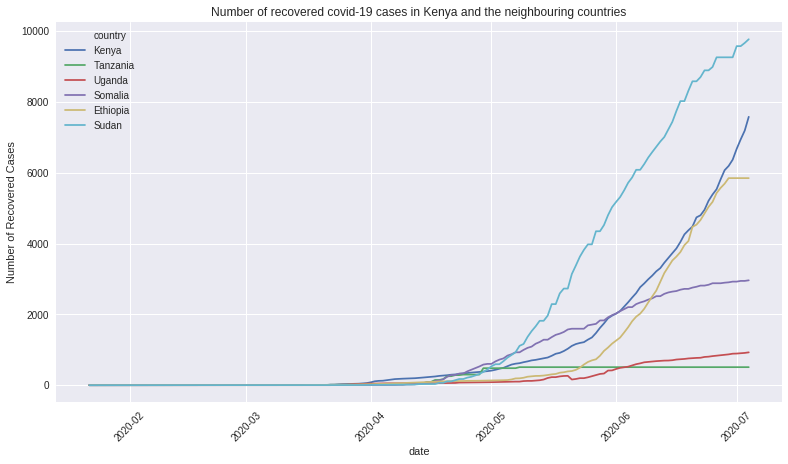

<Figure size 576x396 with 0 Axes>

In [54]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(dfall['date'], dfall['confirmed'], hue = dfall['country'])
plt.xticks(rotation=45)
plt.ylabel('Number of Recovered Cases')
plt.title('Number of recovered covid-19 cases in Kenya and the neighbouring countries')
plt.style.use('seaborn')
plt.show()
plt.savefig('recovered.jpg')

/home/ada/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/ada/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ada/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


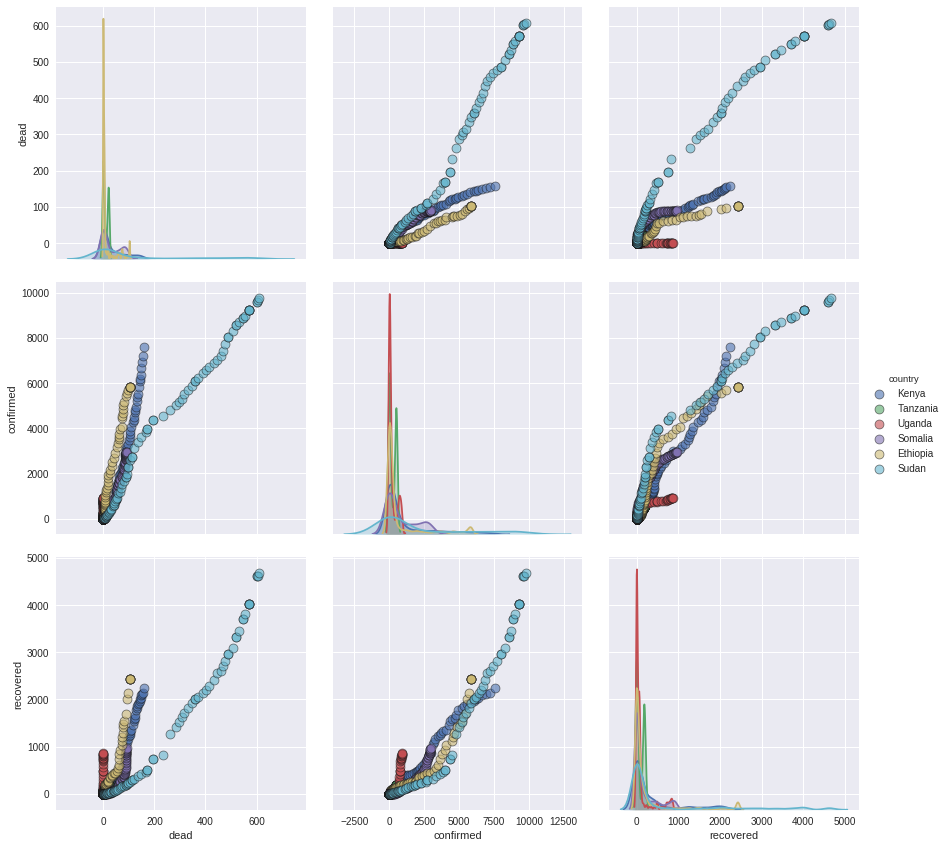

In [55]:
sns.pairplot(data = dfall, vars = ['dead', 'confirmed', 'recovered'], 
             hue = 'country', kind = 'scatter', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.show()

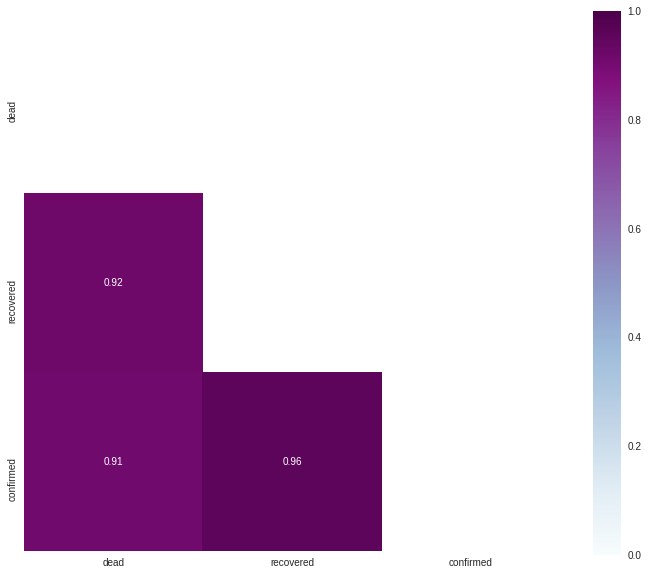

In [56]:
#correlation plot
def correlation_map(data, main_feature, max_relations):
    f_most_correlated = data.corr().nlargest(max_relations,main_feature)[main_feature].index
    f_correlation = data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 10))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

correlation_map(dfall, 'dead', 20)

The 3 variables are obviously correlated since they're a chain of dependent events. For recovery or death to happen, infection has to come first, hence 'confirmed'. That's alos why the pairplots above show a somewhat linear relationship.  What should be interesting is exploring how different factors correlate with infection rate which is equivalent to trend in 'confirmed' numbers.


 mu = 886.62 and sigma = 1816.61



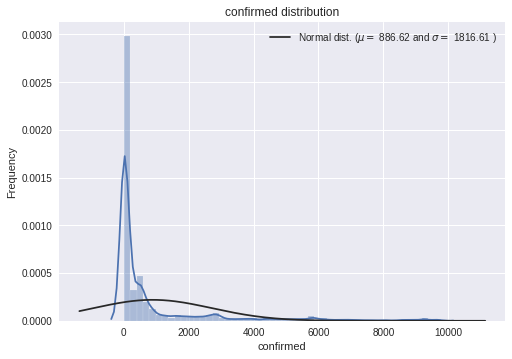

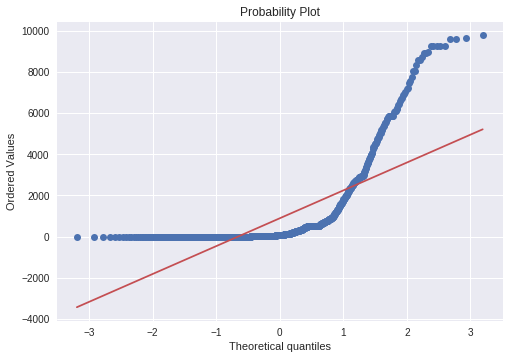


 mu = 275.74 and sigma = 674.95



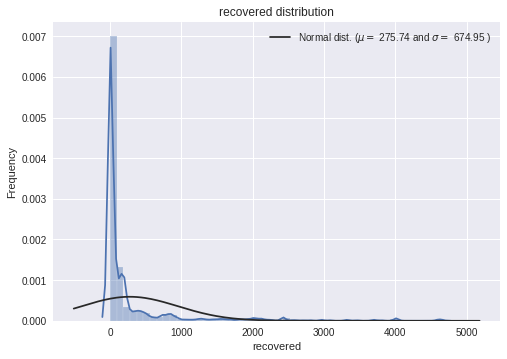

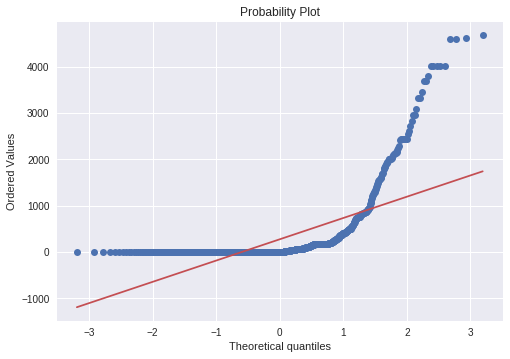


 mu = 34.48 and sigma = 92.29



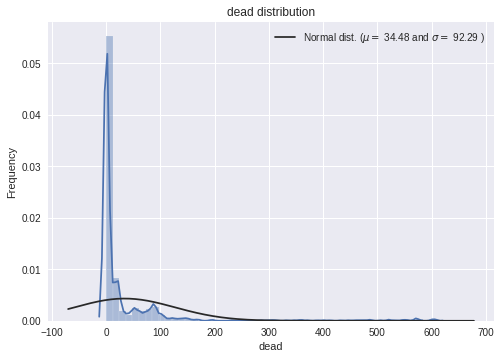

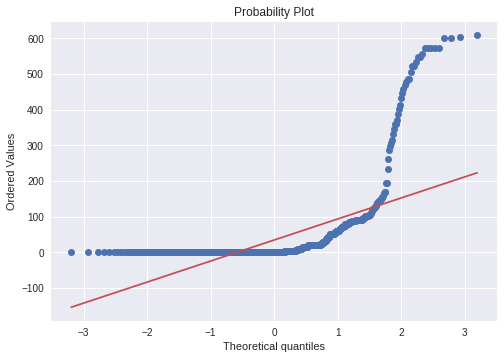

In [57]:
# distribution of the numerical variables
# Target variable
from scipy.stats import skew, norm
from scipy import stats

for col in ['confirmed', 'recovered', 'dead']:
    sns.distplot(dfall[col] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(dfall[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(f'{col} distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(dfall[col], plot=plt)
    plt.show()


They look like rightly-skewed normal distributions.

In [116]:
# sums
k_d = dfall.loc[dfall['country'] == 'Kenya', 'dead'].tail(1)
k_c = dfall.loc[dfall['country'] == 'Kenya', 'confirmed'].tail(1)
k_r =dfall.loc[dfall['country'] == 'Kenya', 'recovered'].tail(1)
e_d =dfall.loc[dfall['country'] == 'Ethiopia', 'dead'].tail(1)
e_c=dfall.loc[dfall['country'] == 'Ethiopia', 'confirmed'].tail(1)
e_r=dfall.loc[dfall['country'] == 'Ethiopia', 'recovered'].tail(1)
t_d =dfall.loc[dfall['country'] == 'Tanzania', 'dead'].tail(1)
t_c=dfall.loc[dfall['country'] == 'Tanzania', 'confirmed'].tail(1)
t_r=dfall.loc[dfall['country'] == 'Tanzania', 'recovered'].tail(1)
u_d =dfall.loc[dfall['country'] == 'Uganda', 'dead'].tail(1)
u_c=dfall.loc[dfall['country'] == 'Uganda', 'confirmed'].tail(1)
u_r=dfall.loc[dfall['country'] == 'Uganda', 'recovered'].tail(1)
ss_d =dfall.loc[dfall['country'] == 'Sudan', 'dead'].tail(1)
ss_c=dfall.loc[dfall['country'] == 'Sudan', 'confirmed'].tail(1)
ss_r=dfall.loc[dfall['country'] == 'Sudan', 'recovered'].tail(1)
s_d =dfall.loc[dfall['country'] == 'Somalia', 'dead'].tail(1)
s_c=dfall.loc[dfall['country'] == 'Somalia', 'confirmed'].tail(1)
s_r=dfall.loc[dfall['country'] == 'Somalia', 'recovered'].tail(1)

dead = [k_d, e_d, u_d, t_d, ss_d, s_d]
confirmed = [k_c, e_c, u_c, t_c, ss_c, s_c]
recovered = [k_r, e_r, u_r, t_r, ss_r, s_r]

In [132]:
# l = np.arange(6)
# w = 0.4
# plt.xticks(l + w / 2, ('Kenya', 'Ethiopia', 'Uganda', 'Tanzania', 'Sudan', 'Somalia'))

# plt.bar(l, dead, w, label="Deaths")
# plt.bar(l + w, confirmed, w, label="Cases")
# plt.title('Covid-19 number of confirmed cases and deaths')
# plt.xlabel('countries')
# plt.ylabel('cases')
# plt.style.use('seaborn-pastel')
# plt.legend()
# plt.show()

In [105]:
# sns.tsplot(dfall, time='date', condition='country', value='dead')

https://twitter.com/kj_adah/status/1279461089718255617 recovery    
https://twitter.com/kj_adah/status/1279460629041086464 deaths

https://twitter.com/kj_adah/status/1279460042950029312 cases